In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
import src.conditioning as con
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle


# Load datasets

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
df = pd.read_csv('./data/diamonds_dataset/train.csv')

In [4]:
test = pd.read_csv('./data/diamonds_dataset/test.csv')

In [5]:
test

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.33,Ideal,H,IF,61.9,55.0,4.44,4.42,2.74
1,1,0.41,Ideal,E,VS2,61.8,54.0,4.79,4.76,2.95
2,2,0.91,Very Good,E,SI2,62.5,59.0,6.16,6.23,3.87
3,3,0.42,Very Good,G,VS2,62.6,57.0,4.76,4.80,2.99
4,4,0.54,Ideal,G,IF,61.5,56.0,5.28,5.25,3.24
...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.55,Ideal,F,SI1,61.7,56.4,5.26,5.30,3.25
13481,13481,1.12,Premium,H,VS2,60.6,59.0,6.77,6.70,4.08
13482,13482,0.37,Ideal,D,SI1,61.5,57.0,4.63,4.60,2.84
13483,13483,0.54,Good,E,SI1,59.9,63.0,5.25,5.30,3.16


In [6]:
id_column_test = test.id

# Data observation

In [7]:
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.53,Very Good,G,SI1,63.4,54.0,5.09,5.13,3.24,7.057
1,1,0.41,Ideal,D,SI1,63.0,56.0,4.80,4.75,3.01,6.824
2,2,0.32,Ideal,I,VS2,61.6,56.0,4.37,4.39,2.70,6.107
3,3,0.31,Ideal,H,VVS2,61.2,56.0,4.34,4.37,2.66,6.390
4,4,1.35,Premium,J,VS2,60.5,56.0,7.19,7.12,4.33,8.741


price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

In [8]:
df.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       40455 non-null  int64  
 1   carat    40455 non-null  float64
 2   cut      40455 non-null  object 
 3   color    40455 non-null  object 
 4   clarity  40455 non-null  object 
 5   depth    40455 non-null  float64
 6   table    40455 non-null  float64
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
 10  price    40455 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 3.4+ MB


### Carat

In [10]:
df.carat.describe()

count    40455.000000
mean         0.795004
std          0.471700
min          0.200000
25%          0.400000
50%          0.700000
75%          1.040000
max          4.500000
Name: carat, dtype: float64

### Cut

In [11]:
df.cut.unique()

array(['Very Good', 'Ideal', 'Premium', 'Good', 'Fair'], dtype=object)

In [12]:
df.cut.value_counts()

Ideal        16154
Premium      10369
Very Good     9054
Good          3663
Fair          1215
Name: cut, dtype: int64

### Color

In [13]:
df.color.unique()

array(['G', 'D', 'I', 'H', 'J', 'F', 'E'], dtype=object)

In [14]:
df.color.value_counts()

G    8477
E    7370
F    7143
H    6196
D    5113
I    4102
J    2054
Name: color, dtype: int64

### Clarity

In [15]:
df.clarity.unique()

array(['SI1', 'VS2', 'VVS2', 'SI2', 'VVS1', 'VS1', 'I1', 'IF'],
      dtype=object)

### x, y, z

In [16]:
df[['x','y','z']].describe()

,x,y,z
count,40455.000000,40455.000000,40455.000000
mean,5.724661,5.727629,3.535011
std,1.119617,1.142047,0.707558
min,0.000000,0.000000,0.000000
25%,4.710000,4.720000,2.910000
50%,5.690000,5.700000,3.520000
75%,6.530000,6.530000,4.030000
max,10.230000,58.900000,31.800000


### Table

In [17]:
df.table.describe()

count    40455.000000
mean        57.451133
std          2.230630
min         43.000000
25%         56.000000
50%         57.000000
75%         59.000000
max         79.000000
Name: table, dtype: float64

# Data Cleaning

### Delete depth column (and 'id)

Depth is a result of a formula based on only  X, Y, Z so we can drop that column

In [18]:
df = df.drop(['depth', 'id'], axis = 1)

### Ordinal encoding of categorial columns

#### Color

https://www.brilliance.com/education/diamonds/color

Based on this website, you can get an idea of color values. As a first approach, let's rank color from 1 to 10 for the 10 types of color codes

In [19]:
df.color.unique()

array(['G', 'D', 'I', 'H', 'J', 'F', 'E'], dtype=object)

Let's have different proposal for color values and try all in the models afterwards

* Simple best score 10 points, lowest score 1 and proportional

In [20]:
color_dict = {'D': 10 , 'E': 9, 'F': 8, 'G': 7, 'H': 6, 'I': 5, 'J': 4, 'K': 3, 'L': 2, 'M': 1}


* Next option, with more gap between main categories

In [21]:
color_dict2 = {'D': 10 , 'E': 9.5, 'F': 9, 'G': 7, 'H': 6.5, 'I': 6, 'J': 5.5, 'K': 3.5, 'L': 3, 'M': 2.5}

In [22]:
df['color_val'] = df.color.apply(lambda x: con.transform_ordinal_cat(x,color_dict ))
df['color_val2'] = df.color.apply(lambda x: con.transform_ordinal_cat(x,color_dict2 ))

#### Clarity

https://4cs.gia.edu/en-us/diamond-clarity/

Same approach for clarity

In [23]:
df.clarity.unique()

array(['SI1', 'VS2', 'VVS2', 'SI2', 'VVS1', 'VS1', 'I1', 'IF'],
      dtype=object)

In [24]:
clarity_dict = {'I3': 1 , 'I2': 2, 'I1': 3, 'SI2': 4, 'SI1': 5, 'VS2': 6, 'VS1': 7, 'VVS2': 8, 'VVS1': 9, 'IF': 10 }

In [25]:
clarity_dict2 = {'I3': 1 , 'I2': 1.5, 'I1': 2, 'SI2': 4, 'SI1': 4.5, 'VS2': 6.5, 'VS1': 7, 'VVS2': 9, 'VVS1': 9.5, 'IF': 11.5 }

In [26]:
df['clar_val'] = df.clarity.apply(lambda x: con.transform_ordinal_cat(x,clarity_dict ))
df['clar_val2'] = df.clarity.apply(lambda x: con.transform_ordinal_cat(x,clarity_dict2 ))

#### Cut

In [27]:
df.cut.unique()

array(['Very Good', 'Ideal', 'Premium', 'Good', 'Fair'], dtype=object)

In [28]:
cut_dict = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}

In [29]:
df

,carat,cut,color,clarity,table,x,y,z,price,color_val,color_val2,clar_val,clar_val2
0,0.53,Very Good,G,SI1,54.0,5.09,5.13,3.24,7.057,7,7.0,5,4.5
1,0.41,Ideal,D,SI1,56.0,4.80,4.75,3.01,6.824,10,10.0,5,4.5
2,0.32,Ideal,I,VS2,56.0,4.37,4.39,2.70,6.107,5,6.0,6,6.5
3,0.31,Ideal,H,VVS2,56.0,4.34,4.37,2.66,6.390,6,6.5,8,9.0
4,1.35,Premium,J,VS2,56.0,7.19,7.12,4.33,8.741,4,5.5,6,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0.52,Premium,D,VS2,58.0,5.16,5.20,3.17,7.508,10,10.0,6,6.5
40451,0.52,Ideal,F,SI1,55.0,5.14,5.17,3.19,7.232,8,9.0,5,4.5
40452,0.73,Very Good,D,VS2,58.0,5.68,5.72,3.62,8.065,10,10.0,6,6.5
40453,0.31,Fair,F,VVS2,59.0,4.45,4.48,2.54,6.629,8,9.0,8,9.0


In [30]:
df['cut_val'] = df.cut.apply(lambda x: con.transform_ordinal_cat(x,cut_dict))

# Generation Dataframes

Since we have different approaches to value ordinal categories, let's prepare dataframes for all combinations. 
I.e. 4 dataframes (2 types of colors, and 2 types of clarities

In [31]:
X_1 = df.drop(['price','cut','color','clarity','color_val2', 'clar_val2'], axis = 1)
X_2 = df.drop(['price','cut','color','clarity','color_val', 'clar_val2'], axis = 1)
X_3 = df.drop(['price','cut','color','clarity','color_val2', 'clar_val'], axis = 1)
X_4 = df.drop(['price','cut','color','clarity','color_val', 'clar_val'], axis = 1)


In [32]:
y = df.price

# Train-test split

Due to amount of instances, let's split 80-20

In [33]:
X1_train, X1_test, y_train, y_test = train_test_split(X_1, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)
X2_train, X2_test, y_train, y_test = train_test_split(X_2, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)
X3_train, X3_test, y_train, y_test = train_test_split(X_3, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)
X4_train, X4_test, y_train, y_test = train_test_split(X_4, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)

# Modelization

## Linear regression

For reference

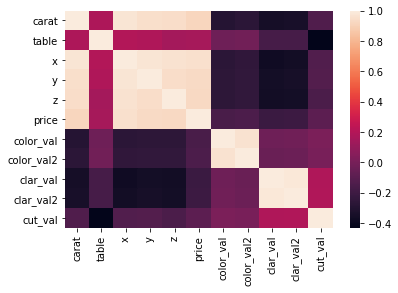

In [34]:
sns.heatmap(df.corr())

In [35]:
X_train_total = [X1_train, X2_train, X3_train, X4_train]
X_test_total = [X1_test, X2_test, X3_test, X4_test]

In [85]:
scores = []
coefs = []
intercepts = []
models = []

for X_train, X_test in zip(X_train_total, X_test_total):
    
    lr = LinearRegression()

    lr.fit(X_train, y_train)
    
    y_predict_test = lr.predict(X_test)
    
    scores.append(mean_squared_error(y_test, y_predict_test))
    
    coefs.append(lr.coef_)
    
    intercepts.append(lr.intercept_)
    models.append(lr)
    
    

In [86]:
scores = []
coefs = []
intercepts = []
models = []


    
lr = LinearRegression()

lr.fit(X1_train, y_train)

y_predict_test = lr.predict(X1_test)

scores.append(mean_squared_error(y_test, y_predict_test))

coefs.append(lr.coef_)

intercepts.append(lr.intercept_)
models.append(lr)

Let's see if we are having overfitting

In [143]:
mean_squared_error(models[0].predict(X1_train), y_train)

0.03970626530709465

There is no overfitting, so we will not implement a regularization model like Lasso, Ridge or Elastic

Let's train the best lr model with all the training set for submit

In [144]:
lr = LinearRegression()
lr.fit(X_1, y)

LinearRegression()

In [161]:
y_predict = lr.predict(X_1)

In [162]:
mean_squared_error(y, y_predict)

0.03965681457183382

Now lets condition our test sample

In [146]:
test_clean = con.condition_test(test, color_dict, clarity_dict, cut_dict)

In [147]:
test_clean

,carat,table,x,y,z,color_val,clar_val,cut_val
0,0.33,55.0,4.44,4.42,2.74,6,10,5
1,0.41,54.0,4.79,4.76,2.95,9,6,5
2,0.91,59.0,6.16,6.23,3.87,9,4,3
3,0.42,57.0,4.76,4.80,2.99,7,6,3
4,0.54,56.0,5.28,5.25,3.24,7,10,5
...,...,...,...,...,...,...,...,...
13480,0.55,56.4,5.26,5.30,3.25,8,5,5
13481,1.12,59.0,6.77,6.70,4.08,6,6,4
13482,0.37,57.0,4.63,4.60,2.84,10,5,5
13483,0.54,63.0,5.25,5.30,3.16,9,5,2


In [151]:
real_test_pred = lr.predict(test_clean)

In [164]:
con.create_csv(id_column_test, real_test_pred, './output/linear_0.03965.csv')

In [87]:
pickle.dump(models[0], open("lr.pickle_half.dat", "wb"))

## KNN

Let's first standarize our data

In [88]:
scores = []
params = []
models = []

for X_train, X_test in zip(X_train_total, X_test_total):
    
    knn = make_pipeline(StandardScaler(),
                            KNeighborsRegressor())
       
    n_neighbors = np.arange(1,20)
    parameter_space = {'kneighborsregressor__n_neighbors': n_neighbors,
                       }

    grid_search = GridSearchCV(knn,
                           param_grid=parameter_space,
                           verbose=1,
                           n_jobs=-1,
                           cv=5)
    
    grid_search.fit(X_train, y_train)
    
    knn_best = grid_search.best_estimator_
    
    y_predict_test = knn_best.predict(X_test) 

   
    scores.append(mean_squared_error(y_test, y_predict_test))
    
    params.append(grid_search.best_params_)
    
    models.append(knn_best)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    6.2s finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    4.4s finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    4.5s finished


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    4.4s finished


In [54]:
scores

[0.016390784300800616,
 0.016309983606613655,
 0.016395920682239523,
 0.01639383184278828]

In [55]:
params

[{'kneighborsregressor__n_neighbors': 6},
 {'kneighborsregressor__n_neighbors': 6},
 {'kneighborsregressor__n_neighbors': 5},
 {'kneighborsregressor__n_neighbors': 5}]

Let's keep best KNN, train to all train set for submission

In [89]:
knn = models[1]

In [241]:
knn.fit(X_2,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=6))])

In [244]:
y_predict = knn.predict(X_2)
mean_squared_error(y, y_predict)

0.010410327070544774

In [90]:
pickle.dump(models[0], open("knn_half.pickle.dat", "wb"))

In [242]:
test_clean = con.condition_test(test, color_dict2, clarity_dict, cut_dict)

In [243]:
real_test_pred = knn.predict(test_clean)

In [245]:
con.create_csv(id_column_test, real_test_pred, './output/knn_0.0104.csv')

## Random Forest

In [ ]:
X_train_total = [X1_train, X2_train, X3_train, X4_train]
X_test_total = [X1_test, X2_test, X3_test, X4_test]

In [38]:
    
rf = RandomForestRegressor()

parameter_space = {'n_estimators': [300],
               'max_features': [0.6],
               'max_depth': [150, 200],
               'min_samples_leaf': [1]}

grid_search = GridSearchCV(rf,
                   param_grid=parameter_space,
                   verbose=1,
                    n_jobs= None,
                   cv=5)

grid_search.fit(X1_train, y_train)

rf_best = grid_search.best_estimator_
y_predict_test = rf_best.predict(X1_test) 

score = mean_squared_error(y_test, y_predict_test)

params = (grid_search.best_params_)

    

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished


In [39]:
score

0.008642281785282658

In [40]:
params

{'max_depth': 150,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [41]:
rf_best.fit(X_1,y)

RandomForestRegressor(max_depth=150, max_features=0.6, n_estimators=300)

In [42]:
y_predict = rf_best.predict(X_1)
mean_squared_error(y, y_predict)

0.0010991499944998416

In [43]:
test_clean = con.condition_test(test, color_dict, clarity_dict, cut_dict)

In [42]:
real_test_pred = rf_best.predict(test_clean)

In [43]:
con.create_csv(id_column_test, real_test_pred, './output/rf_0.00109508.csv')

In [80]:
pickle.dump(rf, open("RF_150_0.6_300_half.pickle.dat", "wb"))

## KG Boost

In [46]:
gb = GradientBoostingRegressor(n_estimators= 3000)

parameter_space = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
               'max_features': [1, 0.5, 0.3, 0.1],
               'max_depth': [4,6],
               'min_samples_leaf': [1, 3, 10]}

grid_search = GridSearchCV(gb,
                   param_grid=parameter_space,
                   verbose=1,
                    n_jobs= -1,
                   cv=5)

grid_search.fit(X1_train, y_train)

gb_best = grid_search.best_estimator_
y_predict_test = gb_best.predict(X1_test) 

score = mean_squared_error(y_test, y_predict_test)

params = (grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 28.7min finished


In [47]:
score

0.0077191892285022054

In [48]:
params

{'learning_rate': 0.02,
 'max_depth': 6,
 'max_features': 0.5,
 'min_samples_leaf': 1}

In [49]:
gb_best.fit(X_1,y)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, max_features=0.5,
                          n_estimators=3000)

In [50]:
y_predict = gb_best.predict(X_1)
mean_squared_error(y, y_predict)

0.004350899492879355

In [51]:
test_clean = con.condition_test(test, color_dict, clarity_dict, cut_dict)

In [52]:
real_test_pred = rf_best.predict(test_clean)

In [53]:
con.create_csv(id_column_test, real_test_pred, './output/gb_0.00435.csv')

In [10]:
X_train, X_test, y_train, y_test = con.prepare_data(df, color_dict, clarity_dict, cut_dict, 0.2)


In [106]:
gb = GradientBoostingRegressor()

parameter_space = {'n_estimators': [31000],
    'learning_rate': [0.0032],
               'max_features': [0.4],
               'max_depth': [8],
               'min_samples_leaf': [10]}

grid_search = GridSearchCV(gb,
                   param_grid=parameter_space,
                   verbose=1,
                    n_jobs= -1,
                   cv=5,
                    scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_
y_predict_test = gb_best.predict(X_test) 

score = mean_squared_error(y_test, y_predict_test)

params = (grid_search.best_params_)

NameError: name 'X_train' is not defined

In [71]:
gb = GradientBoostingRegressor(n_estimators = 31000,
                    learning_rate= 0.0032,
               max_features= 0.4,
               max_depth= 8,
               min_samples_leaf= 10)



gb.fit(X_train, y_train)

y_predict_test = gb.predict(X_test) 

score = mean_squared_error(y_test, y_predict_test)


In [12]:
score

0.007470164678592575

In [184]:
score

0.007470588414130163

In [28]:
gb_best.fit(X_1,y)

GradientBoostingRegressor(learning_rate=0.0032, max_depth=8, max_features=0.4,
                          min_samples_leaf=10, n_estimators=30000)

In [29]:
y_predict = gb_best.predict(X_1)
mse = mean_squared_error(y, y_predict)
test_clean = con.condition_test(test, color_dict, clarity_dict, cut_dict)
real_test_pred = gb_best.predict(test_clean)


In [68]:
mse

0.00356022453831614

In [30]:
con.create_csv(id_column_test, real_test_pred, './output/gb_mse_0.0074701646_30000_0.0032_8_0.4_10.csv')

In [70]:
pickle.dump(gb_best, open("GB_0.00724.pickle.dat", "wb"))

In [ ]:
loaded_model = gb_best.load(open("pima.pickle.dat", "rb"))

## Stacking

In [42]:
model1 = pickle.load(open("./data/models/GB_0.0zcvzcv0744760_half_learn.pickle.dat", "rb"))
model2 = pickle.load(open("./data/models/RF_150_0.6_300_half.pickle.dat", "rb"))
model3 = pickle.load(open("./data/models/knn_half.pickle.dat", "rb"))
model4 = pickle.load(open("./data/models/lr.pickle_half.dat", "rb"))

In [43]:
models = [model1, model2, model3, model4]

In [44]:
pred_train = []
pred_test = []
for model in models:
    pred_train.append(model.predict(X1_train))
    pred_test.append(model.predict(X1_test))
    

In [45]:
X_train_stack = pd.DataFrame(pred_train).T
X_test_stack = pd.DataFrame(pred_test).T

### Lasso as meta model

In [47]:
lr_stack = LassoCV(eps=1e-7, n_alphas=1000, cv=5, random_state=0, max_iter= 10000)

lr_stack.fit(X_train_stack, y_train)

y_predict_test = lr_stack.predict(X_test_stack)

score_stack = mean_squared_error(y_test, y_predict_test)


In [48]:
score_stack

0.00428773538083001

In [54]:
alphha = lr_stack.alpha_

In [50]:
pred_full = []

for model in models:
    pred_full.append(model.predict(X_1))


In [62]:
alphha

7.443720944875631e-07

In [51]:
X_full_stack = pd.DataFrame(pred_full).T


In [56]:
lasso_stack_full = Lasso(alpha=alphha, max_iter= 10000)
lasso_stack_full.fit(X_full_stack, y)

Lasso(alpha=7.443720944875631e-07, max_iter=10000)

In [57]:
pred_kag = []
test_clean = con.condition_test(test, color_dict, clarity_dict, cut_dict)
for model in models:
    pred_kag.append(model.predict(test_clean))

In [58]:
X_kag = pd.DataFrame(pred_kag).T

In [59]:
pred_kag = lasso_stack_full.predict(X_kag)

In [60]:
con.create_csv(id_column_test, pred_kag, './output/stack_lr_v_final.csv')

### Gradient boost as meta model

In [69]:
X_train_final_stack = pd.concat([X_train_stack, X1_train.reset_index()], axis=1, ignore_index=True)

In [71]:
X_test_final_stack = pd.concat([X_test_stack, X1_test.reset_index()], axis=1, ignore_index=True)

In [ ]:
learning_rate= 0.0032

In [80]:
final_model_stack = GradientBoostingRegressor()

parameter_space = {'n_estimators' : [2000, 5000],
                'learning_rate': [0.01,0.015],
               'max_features': [None, 0.5],
               'max_depth': [8],
               'min_samples_leaf': [5]}

grid_search_final = GridSearchCV(final_model_stack,
                   param_grid=parameter_space,
                   verbose=1,
                    n_jobs= -1,
                   cv=5,
                    scoring='neg_mean_absolute_error')

grid_search_final.fit(X_train_final_stack, y_train)

final_model_stack_best = grid_search_final.best_estimator_
y_predict_final_test = final_model_stack_best.predict(X_test_final_stack) 

score_final = mean_squared_error(y_test, y_predict_final_test)

params_final = (grid_search_final.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 41.3min finished


In [83]:
gb_final = GradientBoostingRegressor(n_estimators = 5000,
                    learning_rate= 0.005,
               max_features= 0.5,
               max_depth= 8,
               min_samples_leaf= 5)



gb_final.fit(X_train_final_stack, y_train)



NameError: name 'gb' is not defined

In [99]:
rf = RandomForestRegressor(n_estimators = 500,
               max_features= 0.6,
               max_depth= 300,
               min_samples_leaf= 5)



rf.fit(X_train_final_stack, y_train)

y_predict_test = rf.predict(X_test_final_stack) 

score_1 = mean_squared_error(y_test, y_predict_test)

In [100]:
score_1

0.004982067110234239

In [101]:
X_fullfit = pd.concat([X_full_stack, X_1.reset_index()], axis=1, ignore_index=True)

In [102]:
rf.fit(X_fullfit, y)

RandomForestRegressor(max_depth=300, max_features=0.6, min_samples_leaf=5,
                      n_estimators=500)

In [103]:
X_test_final_kag = pd.concat([X_kag, test_clean.reset_index()], axis=1, ignore_index=True)

In [104]:
predictions_kaggle = rf.predict(X_test_final_kag)

In [105]:
con.create_csv(id_column_test, predictions_kaggle, './output/stack_rf.csv')